In [24]:
import numpy as np
import pandas as pd
import datetime as dt
from pandas_datareader.data import DataReader
import matplotlib.pyplot as plt
import time

Symbols,MSFT,IBM,AAPL,GOOG
Date,,,,
2021-05-19,4.162759,1.050937,4.548510,2.936767
2021-05-20,4.220290,1.056001,4.644084,2.997036
2021-05-21,4.197860,1.062313,4.575504,2.983057
2021-05-24,4.293916,1.062166,4.636423,3.061376
2021-05-25,4.310011,1.055341,4.629128,3.064429


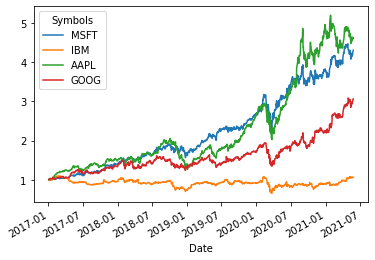

In [25]:
# load data 
stocks = DataReader(['MSFT', 'IBM', 'AAPL', 'GOOG'], 'yahoo', start=dt.datetime(2017,1,1),end=dt.datetime(2021,5,25))['Adj Close']
# plot normalized prices of these stocks
normalized_price = stocks / stocks.iloc[0,:]
normalized_price.plot()
normalized_price.tail()
# data.shape
# stocks.plot()

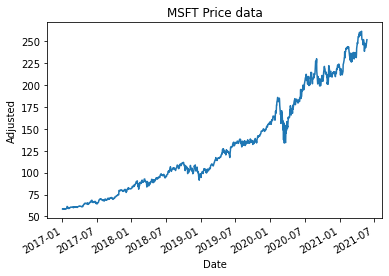

In [26]:
stocks['MSFT'].plot()
plt.xlabel("Date")
plt.ylabel("Adjusted")
plt.title("MSFT Price data")
plt.show()

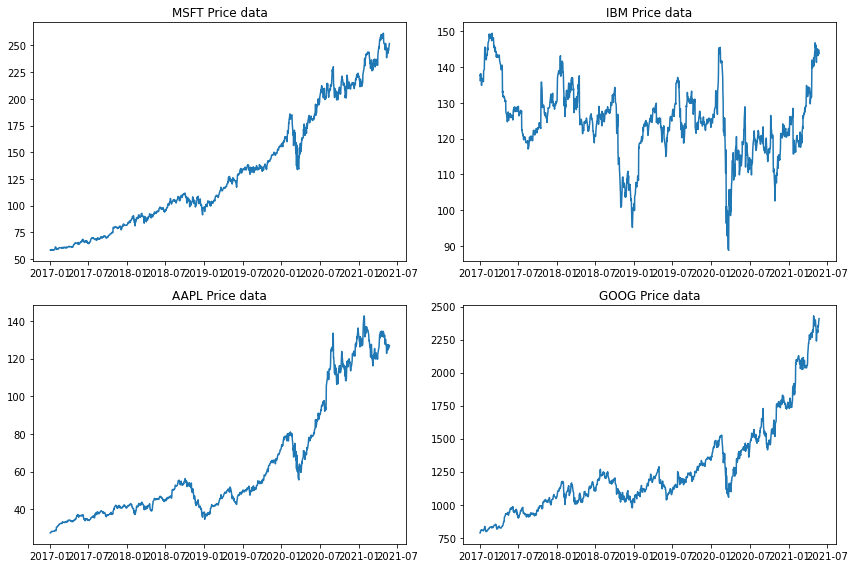

In [27]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
ax1.plot(stocks['MSFT'])
ax1.set_title("MSFT Price data")
ax2.plot(stocks['IBM'])
ax2.set_title("IBM Price data")
ax3.plot(stocks['AAPL'])
ax3.set_title("AAPL Price data")
ax4.plot(stocks['GOOG'])
ax4.set_title("GOOG Price data")
plt.tight_layout()
plt.show()

In [28]:
stocks.describe()

Symbols,MSFT,IBM,AAPL,GOOG
count,1106.000000,1106.000000,1106.000000,1106.000000
mean,131.704419,124.884073,63.349726,1260.381748
std,57.005517,10.005240,31.966140,349.785041
min,58.142242,88.795891,27.382690,786.140015
25%,86.622334,119.756485,40.623611,1039.482483
50%,113.403908,124.833046,49.595364,1164.280029
75%,177.502026,130.000252,78.222795,1416.349976
max,261.366486,149.450806,142.704010,2429.889893


In [29]:
data = stocks/stocks.shift(1) # pt/pt-1
data = data.dropna(how='all') # delete 'NaN'
x = data.to_numpy() # relative price
#data.info()
N=x.shape[0]
d=x.shape[1]
# x=np.zeros((N,d))
b=np.ones(d)/d
x

array([[0.99552552, 1.01238108, 0.99888078, 1.00096676],
       [1.        , 0.99669153, 1.00508546, 1.00904816],
       [1.00866783, 1.00491991, 1.01114819, 1.0152767 ],
       ...,
       [0.99468518, 1.00597721, 0.98523292, 0.9953355 ],
       [1.02288208, 0.99986179, 1.01331418, 1.02625467],
       [1.00374832, 0.99357374, 0.99842646, 1.00099729]])

In [30]:
def simplex_proj(y):
    """ Projection of y onto simplex. """
    m = len(y)
    bget = False
    s = sorted(y, reverse=True)
    tmpsum = 0.
    for ii in range(m-1):
        tmpsum = tmpsum + s[ii]
        tmax = (tmpsum - 1) / (ii + 1);
        if tmax >= s[ii+1]:
            bget = True
            break
    if not bget:
        tmax = (tmpsum + s[m-1] -1)/m

    return np.maximum(y-tmax,0.)

In [31]:
#  Simple moving average, p totals have omega-1 row data,its ,relative_prices
def SMA_predict(omega,p,d): # omega: SMA Window size , d = p.shape[1] -> stocks_number
    unit_vector = np.ones(d)
    SMA_predict = np.zeros(d)
    SMA_predict += unit_vector
    for i in range(1,omega):
        x = np.ones(d)
        for j in range(i):
            x *= p.iloc[omega-j-2,:]
        SMA_predict += 1.0/x
    SMA_predict = SMA_predict/omega
    return SMA_predict

In [32]:
start = time.time()
cum_ret=1 # Initialization
epsilon=5 # Reversion threshold
w=10 # SMA Window size
daily_r=np.ones(N)
b=np.ones(d)/d

for t in range(N-1):
    x[t+1] = SMA_predict(w,data,d)
    x_bar = np.mean(x[t+1])
    denominator = np.sum((x[t+1] - np.mean(x[t+1]))**2)
    molecular  = epsilon - np.dot(b,x[t+1])
    lambd = np.maximum(0, molecular / denominator)
    b = b + lambd * (x[t+1] - x_bar) #- gamma * (y[t+1] - y_bar)
    b = simplex_proj(b)
    daily_r[t] = np.dot(x[t+1],b)
    cum_ret = cum_ret * daily_r[t] 
print("Cumulative return:",cum_ret,"-----> Expressed by scientific counting:",f'{cum_ret:1.2e}') 
end = time.time()
print("Program running time:",end-start)

Cumulative return: 2321.4194609735887 -----> Expressed by scientific counting: 2.32e+03
Program running time: 30.670003175735474


Text(0.5, 1.0, 'Daily return Portfolio Value')

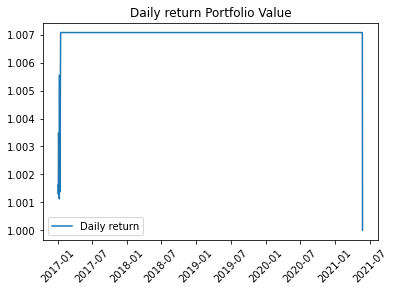

In [33]:
# A chart of daily return ratio over time
plt.plot(data.index,daily_r,label='Daily return')
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.title('Daily return Portfolio Value')

In [34]:
daily_r = pd.DataFrame(daily_r,index = data.index,columns=['daily return'])
# print(daily_r)
mean_daily = daily_r['daily return'].mean()
print("Average daily rate of return:",mean_daily)
mean_return_annualized = mean_daily**252 - 1
print("Annualized mean return ：", mean_return_annualized)

Average daily rate of return: 1.0070382762161867
Annualized mean return ： 4.855802418769473


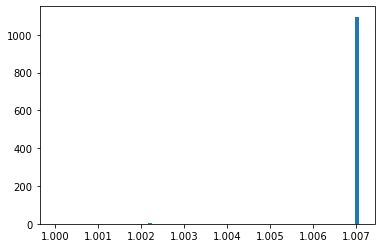

In [35]:
# A histogram of returns
plt.hist(np.array(daily_r), bins=75)
plt.show()

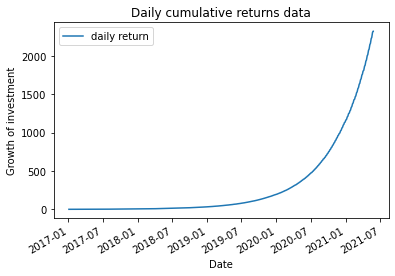

In [36]:
# This chart shows the cumulative returns since 2015 for four datasets.
cum_returns = daily_r.cumprod()
cum_returns.plot()
plt.xlabel("Date")
plt.ylabel("Growth of investment")
plt.title("Daily cumulative returns data")
plt.show()

In [37]:
std_daily = np.std(np.array(daily_r))
print("Daily rate return standard deviation: ", std_daily)
variance_daily = std_daily ** 2
print("Daily rate return variance: ", variance_daily)
std_annualized = std_daily*np.sqrt(252)
print("Annualized standard deviation：", std_annualized)
variance_annualized = std_annualized ** 2
print("Annualized variance：", variance_annualized)

Daily rate return standard deviation:  0.0004674267721434626
Daily rate return variance:  2.1848778731645652e-07
Annualized standard deviation： 0.0074201699713515356
Annualized variance： 5.5058922403747046e-05


In [38]:
volatility = std_daily * np.sqrt(252)
print("Volatility is: ",volatility)
SR = mean_daily/std_daily
print("Daily Sharpe ratio is: ",SR)
ASR=np.sqrt(252)*SR
print("Annualized Sharpe ratio is: ",ASR)

Volatility is:  0.0074201699713515356
Daily Sharpe ratio is:  2154.4300331755635
Annualized Sharpe ratio is:  34200.51650922706


In [39]:
# Max Drawdown
maximum = np.maximum.accumulate(np.array(daily_r))
MDD = ((maximum - np.array(daily_r)) / maximum).max()
print("Max Drawdown is: ",MDD)
CS = mean_return_annualized/MDD
print("Calmar Ratio is: ",CS)
win_rate = np.sum(np.array(daily_r)>=1) / np.array(daily_r).size
print("Winning days rate: ",win_rate)


Max Drawdown is:  0.007029022740739559
Calmar Ratio is:  690.8218393754363
Winning days rate:  1.0


In [40]:
# ph=np.arange(-0.5,0.5,0.05)
epsilon=np.arange(0,10,0.5)
w=10 # Confidence parameter for profitable mean reversion portfolio.Recommended value is 0.95.

cum_ret=np.ones(20) # Initialization
# epsilon=5 # Reversion threshold
# w=10 # SMA Window size

daily_r=np.ones(N)
b=np.ones(d)/d
for r in range(20):
    eps = epsilon[r]
    for t in range(N-1):
        x[t+1] = SMA_predict(w,data,d)
        x_bar = np.mean(x[t+1])
        denominator = np.sum((x[t+1] - np.mean(x[t+1]))**2)
        molecular  = eps - np.dot(b,x[t+1])
        lambd = np.maximum(0, molecular / denominator)
        b = b + lambd * (x[t+1] - x_bar) #- gamma * (y[t+1] - y_bar)
        b = simplex_proj(b)
        daily_r[t] = np.dot(x[t+1],b)
        cum_ret = cum_ret * daily_r[t] 
        cum_ret[r] = cum_ret[r] * daily_r[t] 
    print("Cumulative return:",cum_ret[r]) 
print("Cumulative return epsilon:",cum_ret) 


Cumulative return: 0.23925109887940837
Cumulative return: 0.27087940478023353
Cumulative return: 41.64041556989917
Cumulative return: 10.231778472445082
Cumulative return: 6.935282121538037
Cumulative return: 19.527387576380477
Cumulative return: 20.080954295616475
Cumulative return: 36.43052080846743
Cumulative return: 87.21445141095924
Cumulative return: 100.69349066617464
Cumulative return: 58.79949202400157
Cumulative return: 71.81216614885871
Cumulative return: 83.37339117669627
Cumulative return: 114.80709184714571
Cumulative return: 164.79510163608936
Cumulative return: 167.93905625030413
Cumulative return: 144.00545917908585
Cumulative return: 145.48515963741522
Cumulative return: 167.00172721124503
Cumulative return: 212.28278282903375
Cumulative return epsilon: [  88.86454735  135.19980661 1943.15905515  294.52556202  190.44465129
  312.1225727   241.48128098  282.11945282  350.29088321  271.06389214
  169.579248    193.97660777  202.27405511  224.95284833  242.2056784
  211.

Text(0.5, 1.0, 'Daily return value with different Epsilon size')

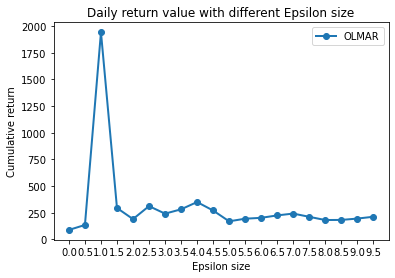

In [41]:
# A chart of daily return ratio over epsilon
plt.plot(epsilon,cum_ret,label='OLMAR',linewidth=2,marker='o',markersize=6)
# plt.xticks(rotation=45)
plt.xticks(np.arange(0,10,0.5))
plt.xlabel('Epsilon size')
plt.ylabel('Cumulative return')
plt.legend(loc='best')
plt.title('Daily return value with different Epsilon size')

In [42]:
# ph=np.arange(-0.5,0.5,0.05)
# epsilon=np.arange(0,10,0.2)
windows=np.arange(0,20,1) # Confidence parameter for profitable mean reversion portfolio.Recommended value is 0.95.
epsilon=5 # Reversion threshold
# w=10 # SMA Window size
cum_ret=np.ones(20) # Initialization

daily_r=np.ones(N)
b=np.ones(d)/d
for r in range(20):
    w = windows[r]
    for t in range(N-1):
        x[t+1] = SMA_predict(w,data,d)
        x_bar = np.mean(x[t+1])
        denominator = np.sum((x[t+1] - np.mean(x[t+1]))**2)
        molecular  = eps - np.dot(b,x[t+1])
        lambd = np.maximum(0, molecular / denominator)
        b = b + lambd * (x[t+1] - x_bar) #- gamma * (y[t+1] - y_bar)
        b = simplex_proj(b)
        daily_r[t] = np.dot(x[t+1],b)
        cum_ret = cum_ret * daily_r[t] 
        cum_ret[r] = cum_ret[r] * daily_r[t] 
    print("Cumulative return:",cum_ret[r]) 
print("Cumulative return epsilon:",cum_ret) 

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in subtract
  from ipykernel import kernelapp as app
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in subtract


Cumulative return: nan
Cumulative return: nan
Cumulative return: nan
Cumulative return: nan
Cumulative return: nan
Cumulative return: nan
Cumulative return: nan
Cumulative return: nan
Cumulative return: nan
Cumulative return: nan
Cumulative return: nan
Cumulative return: nan
Cumulative return: nan
Cumulative return: nan
Cumulative return: nan
Cumulative return: nan
Cumulative return: nan
Cumulative return: nan
Cumulative return: nan
Cumulative return: nan
Cumulative return epsilon: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan]


Text(0.5, 1.0, 'Daily return value with different windows size')

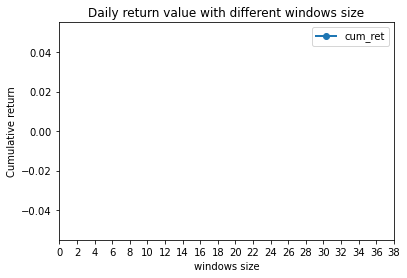

In [43]:
# A chart of daily return ratio over windows
plt.plot(windows,cum_ret,label='cum_ret',linewidth=2,marker='o',markersize=6)
# plt.xticks(rotation=45)
plt.xticks(np.arange(0,40,2))
plt.xlabel('windows size')
plt.ylabel('Cumulative return')
plt.legend(loc='best')
plt.title('Daily return value with different windows size')